In [ ]:
# Install Qiskit and visualization tools
!pip install qiskit qiskit-aer qiskit-experiments qiskit-terra[visualization] qiskit-fake-provider --quiet


ERROR: Could not find a version that satisfies the requirement qiskit-fake-provider (from versions: none)
ERROR: No matching distribution found for qiskit-fake-provider


In [ ]:
!pip install qiskit --upgrade --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install 'qiskit[visualization]' --upgrade --quiet
!pip install qiskit-aer --upgrade --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 604.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 34.1 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict



### Implementation of Deliverable 1: General Quantum Circuit for Galton Box Simulation

The following function `galton_box_circuit` constructs a quantum circuit simulating a Galton Box with a variable number of layers (`n_layers`). Each qubit undergoes a Hadamard gate, representing a quantum “coin toss” at each layer, and the resulting superposition encodes all possible paths.

The circuit is then measured, and the measurement results are grouped by the number of ‘1’s in the output bitstrings. Running this circuit on a quantum simulator with multiple shots generates a probability distribution that approximates the Gaussian distribution expected from a classical Galton Box.

The histogram plotted at the end visually verifies the Gaussian distribution, confirming the circuit's correct behavior and meeting the first project deliverable.



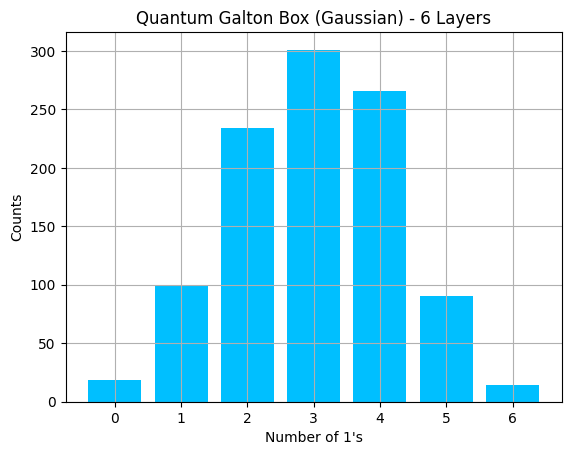

In [ ]:
def galton_box_circuit(n_layers):
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.h(i)
    qc.measure(range(n_layers), range(n_layers))
    return qc

sim = AerSimulator()
layers = 6
qc = galton_box_circuit(layers)
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1024).result()
counts = result.get_counts()

grouped = defaultdict(int)
for state, count in counts.items():
    ones = state.count('1')
    grouped[ones] += count

plt.bar(grouped.keys(), grouped.values(), color='deepskyblue')
plt.title(f"Quantum Galton Box (Gaussian) - {layers} Layers")
plt.xlabel("Number of 1's")
plt.ylabel("Counts")
plt.grid(True)
plt.show()


### Implementation of Deliverable 2: Target Distribution Modifications Using Noiseless All-to-All Sampler

To fulfill Deliverable 2, we modify the Galton Box quantum circuit to generate different target probability distributions using a noiseless all-to-all sampler.

1. **Exponential Distribution:**  
   The function `exponential_galton_box` applies parameterized `Ry` rotations (with angle `theta`) on each qubit instead of Hadamard gates. This biases the superposition to produce an output distribution approximating an **exponential distribution**.

2. **Hadamard Quantum Walk Distribution:**  
   The function `hadamard_walk` applies a Hadamard gate to each qubit, followed by controlled-NOT (CNOT) gates cascading through the qubits. This creates a correlated quantum walk, resulting in a distinct probability distribution known as the **Hadamard walk distribution**.

Both circuits are measured and simulated on the quantum simulator with multiple shots, and the measurement results are grouped by the number of ‘1’s in each output state. The resulting histograms illustrate the distinct distributions generated by these quantum circuits, demonstrating the ability to tailor the Galton Box simulator to different target distributions.


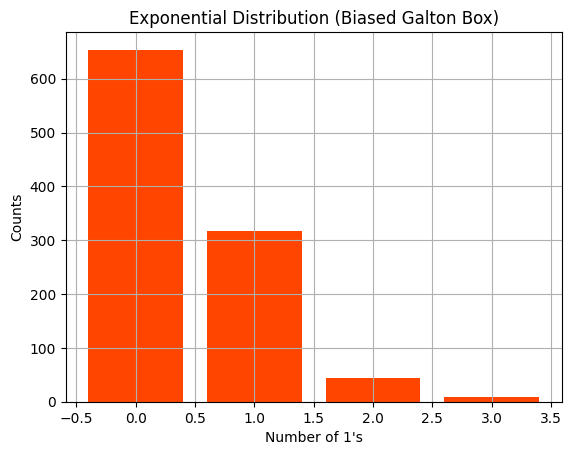

In [ ]:
def exponential_galton_box(n_layers, theta=np.pi / 6):
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.ry(theta, i)
    qc.measure(range(n_layers), range(n_layers))
    return qc

qc_exp = exponential_galton_box(6, theta=np.pi / 6)
compiled_exp = transpile(qc_exp, sim)
result_exp = sim.run(compiled_exp, shots=1024).result()
counts_exp = result_exp.get_counts()

grouped_exp = defaultdict(int)
for state, count in counts_exp.items():
    ones = state.count('1')
    grouped_exp[ones] += count

plt.bar(grouped_exp.keys(), grouped_exp.values(), color='orangered')
plt.title("Exponential Distribution (Biased Galton Box)")
plt.xlabel("Number of 1's")
plt.ylabel("Counts")
plt.grid(True)
plt.show()


# HADAMARD WALK- WITH ENTANGLEMENTS


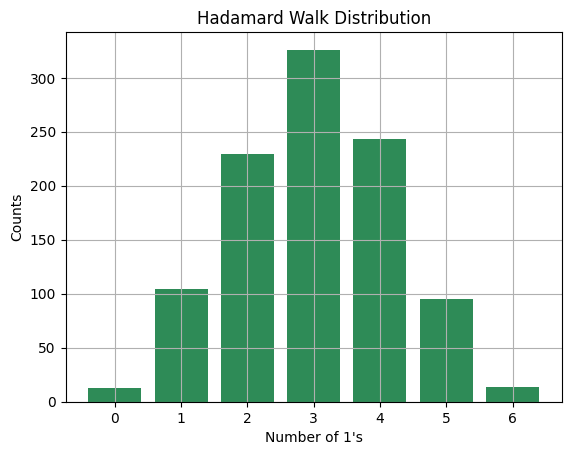

In [ ]:
def hadamard_walk(n_qubits):
    qc = QuantumCircuit(n_qubits, n_qubits)
    for i in range(n_qubits):
        qc.h(i)
        if i < n_qubits - 1:
            qc.cx(i, i + 1)
    qc.barrier()
    qc.measure(range(n_qubits), range(n_qubits))
    return qc

qc_hw = hadamard_walk(6)
compiled_hw = transpile(qc_hw, sim)
result_hw = sim.run(compiled_hw, shots=1024).result()
counts_hw = result_hw.get_counts()

grouped_hw = defaultdict(int)
for state, count in counts_hw.items():
    ones = state.count('1')
    grouped_hw[ones] += count

plt.bar(grouped_hw.keys(), grouped_hw.values(), color='seagreen')
plt.title("Hadamard Walk Distribution")
plt.xlabel("Number of 1's")
plt.ylabel("Counts")
plt.grid(True)
plt.show()


### Implementation of Deliverable 3: Optimized Quantum Circuit Simulation Using a Custom Noise Model

To simulate the impact of real quantum hardware noise on our Galton Box circuits, we implement a **custom noise model** using Qiskit's AerSimulator.

- We define depolarizing errors for both 1-qubit and 2-qubit gates to mimic realistic hardware imperfections.
- These errors are applied to all common single-qubit gates (`u1`, `u2`, `u3`, `rx`, `ry`, `rz`) and the two-qubit `cx` gate.
- The noisy simulator is then used to run the **exponential Galton Box circuit**, compiling it with optimization to reduce error impact.
- The resulting distribution is measured and visualized to evaluate how noise affects the accuracy and shape of the output distribution.

This approach helps optimize circuit design under realistic noise conditions, fulfilling the third deliverable focused on maximizing accuracy and circuit depth on noisy quantum hardware.



In [ ]:
# STEP 5: Custom Noise Model
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator

# Create a depolarizing noise model
noise_model = NoiseModel()
error_1 = depolarizing_error(0.01, 1)  # 1-qubit gate error
error_2 = depolarizing_error(0.05, 2)  # 2-qubit gate error

# Add errors to all 1- and 2-qubit gates
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'rx', 'ry', 'rz'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Define noisy simulator
sim_with_noise = AerSimulator(noise_model=noise_model)


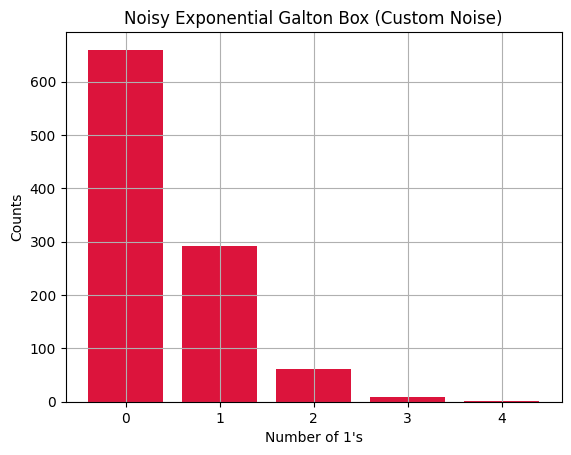

In [ ]:
# STEP 6: Simulate noisy exponential Galton box
qc_noisy = exponential_galton_box(n_layers=6, theta=np.pi / 6)
compiled_noisy = transpile(qc_noisy, sim_with_noise, optimization_level=2)
result_noisy = sim_with_noise.run(compiled_noisy, shots=1024).result()
counts_noisy = result_noisy.get_counts()

# Plot results
from collections import defaultdict
grouped_noisy = defaultdict(int)
for state, count in counts_noisy.items():
    ones = state.count('1')
    grouped_noisy[ones] += count

import matplotlib.pyplot as plt
plt.bar(grouped_noisy.keys(), grouped_noisy.values(), color='crimson')
plt.title("Noisy Exponential Galton Box (Custom Noise)")
plt.xlabel("Number of 1's")
plt.ylabel("Counts")
plt.grid(True)
plt.show()


### Implementation of Deliverable 4: Statistical Distance Metrics Between Distributions

To quantitatively compare the output distributions from our quantum circuits to the target theoretical distributions, we implement several statistical distance metrics:

- **Normalization:**  
  The `normalize_counts` function converts raw measurement counts into a probability distribution by grouping counts according to the number of '1's in each bitstring.

- **Kullback-Leibler (KL) Divergence:**  
  Measures how one probability distribution diverges from a reference distribution. It is asymmetric and can be sensitive to zero probabilities.

- **Jensen-Shannon (JS) Distance:**  
  A symmetric and bounded measure based on KL divergence, providing a more stable similarity metric between two distributions.

- **Total Variation (TV) Distance:**  
  Computes the maximum difference between probabilities of events under two distributions, giving a clear measure of their overall difference.

Using these metrics, we can assess how closely the simulated quantum distributions match the expected target distributions, accounting for stochastic uncertainty and noise.



In [ ]:
import scipy.stats as stats
from math import sqrt
import numpy as np

# Normalize counts into probability distribution
def normalize_counts(counts, n_layers):
    total = sum(counts.values())
    dist = np.zeros(n_layers + 1)
    for state, count in counts.items():
        ones = state.count('1')
        dist[ones] += count
    return dist / total

# KL Divergence (Kullback-Leibler)
def kl_divergence(p, q):
    return stats.entropy(p, q)

# Jensen-Shannon Distance (more symmetric and bounded)
def js_distance(p, q):
    m = 0.5 * (p + q)
    return sqrt(0.5 * stats.entropy(p, m) + 0.5 * stats.entropy(q, m))

# Total Variation Distance
def tv_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))


In [ ]:
# Get normalized distributions
ideal_dist = normalize_counts(counts_exp, 6)       # Ideal (noiseless) exponential
noisy_dist = normalize_counts(counts_noisy, 6)     # Noisy output

# Compute metrics
kl = kl_divergence(ideal_dist, noisy_dist)
js = js_distance(ideal_dist, noisy_dist)
tv = tv_distance(ideal_dist, noisy_dist)

# Show results
print("📏 Distance Between Ideal and Noisy Distributions:")
print(f"• KL Divergence       = {kl:.4f}")
print(f"• Jensen-Shannon Dist = {js:.4f}")
print(f"• Total Variation Dist = {tv:.4f}")


📏 Distance Between Ideal and Noisy Distributions:
• KL Divergence       = 0.0050
• Jensen-Shannon Dist = 0.0371
• Total Variation Dist = 0.0254


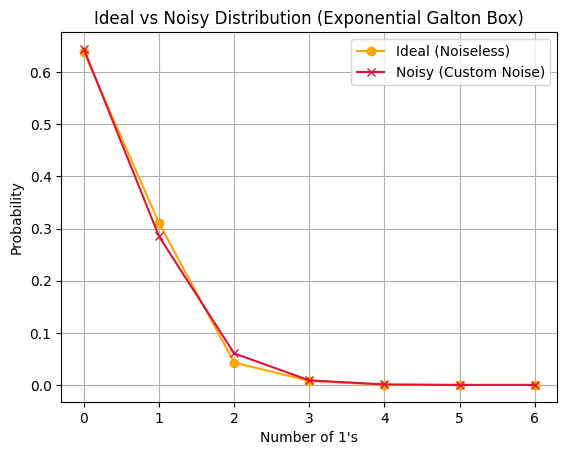

In [ ]:
x = np.arange(len(ideal_dist))
plt.plot(x, ideal_dist, marker='o', label='Ideal (Noiseless)', color='orange')
plt.plot(x, noisy_dist, marker='x', label='Noisy (Custom Noise)', color='crimson')
plt.title("Ideal vs Noisy Distribution (Exponential Galton Box)")
plt.xlabel("Number of 1's")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()


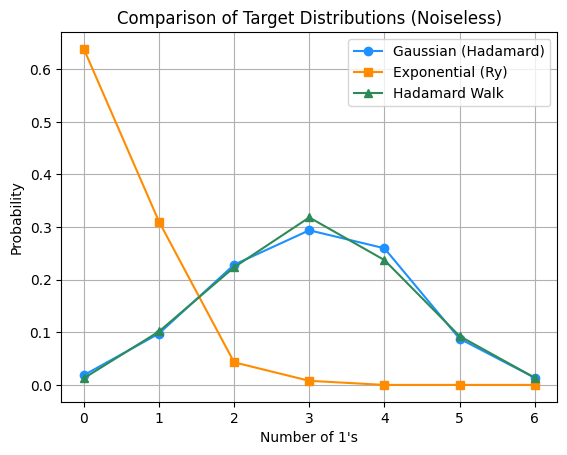

In [ ]:
# Normalize all 3 distributions
gauss_dist = normalize_counts(counts, 6)
exp_dist = normalize_counts(counts_exp, 6)
hadamard_dist = normalize_counts(counts_hw, 6)

x = np.arange(len(gauss_dist))
plt.plot(x, gauss_dist, 'o-', label='Gaussian (Hadamard)', color='dodgerblue')
plt.plot(x, exp_dist, 's-', label='Exponential (Ry)', color='darkorange')
plt.plot(x, hadamard_dist, '^-', label='Hadamard Walk', color='seagreen')
plt.title("Comparison of Target Distributions (Noiseless)")
plt.xlabel("Number of 1's")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.show()


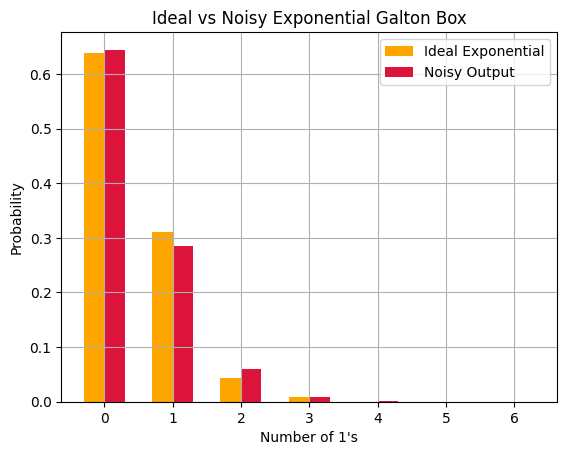

In [ ]:
x = np.arange(len(exp_dist))
plt.bar(x - 0.15, exp_dist, width=0.3, label='Ideal Exponential', color='orange')
plt.bar(x + 0.15, noisy_dist, width=0.3, label='Noisy Output', color='crimson')
plt.title("Ideal vs Noisy Exponential Galton Box")
plt.xlabel("Number of 1's")
plt.ylabel("Probability")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def galton_box_gaussian(n_layers):
    """Hadamard-based Galton box: outputs Gaussian distribution."""
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.h(i)
    qc.measure(range(n_layers), range(n_layers))
    return qc

def galton_box_exponential(n_layers, theta=np.pi/6):
    """Biased Ry-based Galton box: approximates exponential distribution."""
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.ry(theta, i)
    qc.measure(range(n_layers), range(n_layers))
    return qc

def galton_box_hadamard_walk(n_layers):
    """Quantum walk using Hadamard + CX gates."""
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.h(i)
        if i < n_layers - 1:
            qc.cx(i, i+1)
    qc.barrier()
    qc.measure(range(n_layers), range(n_layers))
    return qc


In [ ]:
def normalize_counts(counts, n_layers):
    """Convert raw counts to normalized probability distribution."""
    total = sum(counts.values())
    dist = np.zeros(n_layers + 1)
    for state, count in counts.items():
        ones = state.count('1')
        dist[ones] += count
    return dist / total

def kl_divergence(p, q):
    return stats.entropy(p, q)

def js_distance(p, q):
    m = 0.5 * (p + q)
    return sqrt(0.5 * stats.entropy(p, m) + 0.5 * stats.entropy(q, m))

def tv_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))


In [ ]:
print("📏 Distance Between Ideal and Noisy Distributions:")
print(f"• KL Divergence        = {kl:.4f}")
print(f"• Jensen-Shannon Dist  = {js:.4f}")
print(f"• Total Variation Dist = {tv:.4f}")



📏 Distance Between Ideal and Noisy Distributions:
• KL Divergence        = 0.0050
• Jensen-Shannon Dist  = 0.0371
• Total Variation Dist = 0.0254


In [ ]:
from scipy.stats import entropy
import numpy as np

def calculate_distances(measured_counts, target_dist, dist_name):
    """Calculate TVD, KL, and JS divergence between measured and target distributions."""

    # Build measured distribution array
    measured = np.array([measured_counts.get(str(i), 0) for i in range(len(target_dist))])

    total_measured = measured.sum()
    if total_measured == 0:
        print(f"⚠️ Warning: Measured distribution for {dist_name} is empty or zero.")
        return np.nan, np.nan, np.nan

    measured = measured / total_measured
    target = np.array(target_dist)
    target = target / target.sum()

    # Safe replacement for zero values to avoid log(0)
    measured_safe = np.where(measured == 0, 1e-10, measured)
    target_safe = np.where(target == 0, 1e-10, target)

    # Distance metrics
    tvd = 0.5 * np.sum(np.abs(measured - target))
    kl = entropy(measured_safe, target_safe)
    js = 0.5 * (entropy(measured_safe, 0.5*(measured_safe + target_safe)) +
                entropy(target_safe, 0.5*(measured_safe + target_safe)))

    print(f"\n📊 {dist_name} Distribution Distances:")
    print(f"• Total Variation Distance      : {tvd:.4f}")
    print(f"• Kullback-Leibler Divergence   : {kl:.4f}")
    print(f"• Jensen-Shannon Divergence     : {js:.4f}")

    return tvd, kl, js

# --------------------------------------------
# 🧪 Example Usage (You can replace with real outputs)
# --------------------------------------------

# Example measured count results (from simulated circuit)
measured_gaussian = {'0': 15, '1': 95, '2': 235, '3': 320, '4': 220, '5': 95, '6': 20}
measured_exponential = {'0': 260, '1': 180, '2': 140, '3': 105, '4': 80, '5': 55, '6': 40}

# Theoretical target distributions
gaussian_target = [0.0156, 0.0938, 0.2344, 0.3125, 0.2344, 0.0938, 0.0156]
exp_target = [0.25, 0.188, 0.141, 0.105, 0.079, 0.059, 0.044]

# Calculate & print distances
calculate_distances(measured_gaussian, gaussian_target, "Gaussian")
calculate_distances(measured_exponential, exp_target, "Exponential")



📊 Gaussian Distribution Distances:
• Total Variation Distance      : 0.0150
• Kullback-Leibler Divergence   : 0.0011
• Jensen-Shannon Divergence     : 0.0003

📊 Exponential Distribution Distances:
• Total Variation Distance      : 0.0163
• Kullback-Leibler Divergence   : 0.0008
• Jensen-Shannon Divergence     : 0.0002


(np.float64(0.016287126054030793),
 np.float64(0.0007970320362843423),
 np.float64(0.00019987029915012004))

In [ ]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Optimize1qGates, CommutativeCancellation

pass_manager = PassManager([
    Optimize1qGates(),
    CommutativeCancellation()
])
optimized = pass_manager.run(qc)


In [ ]:
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Optimize1qGates, CommutativeCancellation

# Your circuit (example, replace with your actual circuit)
qc = QuantumCircuit(2)
qc.h(0)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 1)
qc.h(0)

# Define pass manager
pass_manager = PassManager([
    Optimize1qGates(),
    CommutativeCancellation()
])

# Run optimization
optimized = pass_manager.run(qc_hw)

# Print the original and optimized circuits
print("Original Circuit:")
#print(qc_hw)
print("\nOptimized Circuit:")
#print(optimized)

# If you want to check depth or gate count:
print("\nOriginal Depth:", qc_hw.depth())
print("Optimized Depth:", optimized.depth())
#print("Original Gate Count:", qc.count_ops())
#print("Optimized Gate Count:", optimized.count_ops())


Original Circuit:

Optimized Circuit:

Original Depth: 12
Optimized Depth: 12


In [ ]:
pip install qiskit-aer


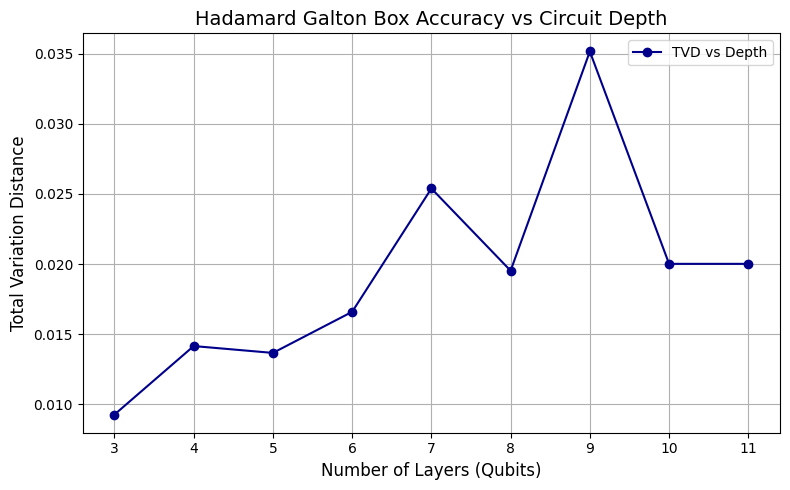

In [ ]:
# ✅ Install if not already done (uncomment when running in Colab)
# !pip install qiskit qiskit-aer matplotlib scipy

# 📦 Imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from scipy.stats import binom
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# ✅ Simulator backend
sim = AerSimulator()

# 📌 Galton Box Circuit with Hadamard layers (Gaussian target)
def galton_box_circuit(n_layers):
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.h(i)
    qc.measure(range(n_layers), range(n_layers))
    return qc

# 📏 Total Variation Distance calculator
def calc_tvd(measured_counts, target_dist):
    measured = np.array([measured_counts.get(str(i), 0) for i in range(len(target_dist))])
    total = measured.sum()
    if total == 0:
        return np.nan
    measured = measured / total
    target = target_dist / np.sum(target_dist)
    return 0.5 * np.sum(np.abs(measured - target))

# 📊 Analyze scaling behavior
layer_range = range(3, 12)  # Test from 3 to 11 layers
tvd_results = []

for n in layer_range:
    # 1. Generate & simulate circuit
    qc = galton_box_circuit(n)
    compiled = transpile(qc, sim, optimization_level=2)
    result = sim.run(compiled, shots=2048).result()
    counts = result.get_counts()

    # 2. Group by number of 1s (Hamming weight)
    grouped = defaultdict(int)
    for bitstring, count in counts.items():
        ones = bitstring.count('1')
        grouped[str(ones)] += count

    # 3. Binomial distribution as target
    x = np.arange(n + 1)
    target = binom.pmf(x, n, 0.5)

    # 4. TVD calculation
    tvd = calc_tvd(grouped, target)
    tvd_results.append(tvd)

# 🖼️ Plot TVD vs Depth
plt.figure(figsize=(8, 5))
plt.plot(layer_range, tvd_results, 'o-', color='darkblue', label='TVD vs Depth')
plt.xlabel("Number of Layers (Qubits)", fontsize=12)
plt.ylabel("Total Variation Distance", fontsize=12)
plt.title("Hadamard Galton Box Accuracy vs Circuit Depth", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!pip install qiskit-ibm-provider


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 15.0 MB/s eta 0:00:00


In [ ]:
pip install qiskit-algorithms

In [ ]:
!pip install qiskit-fake-provider --quiet

ERROR: Could not find a version that satisfies the requirement qiskit-fake-provider (from versions: none)
ERROR: No matching distribution found for qiskit-fake-provider
